Drought Working Group SSTs

In [66]:
from netCDF4 import Dataset
import numpy as np
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

In [67]:
inPath='/shared/ccsm4/kpegion/droughtwg/README/sst_forcing/EOFs/'
cfile='monthly_climatology_sst_ice.nc'
pacfile='Pacific_SST.nc'

In [68]:
inFileClimo='%s%s' %(inPath,cfile)
inFilePac='%s%s' %(inPath,pacfile)

96 60 12
(1, 60, 96)


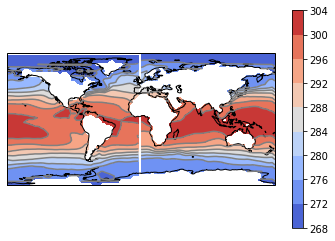

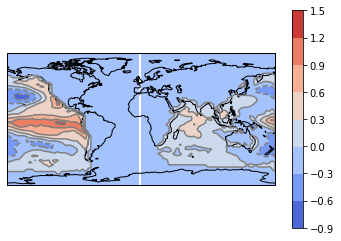

In [69]:
# Read Climo File
ncfile1=Dataset(inFileClimo,'r')
lats = ncfile1.variables['lat'][:]
ny=lats.size
lons = ncfile1.variables['lon'][:]
nx=lons.size
nctime = ncfile1.variables['time'][:]
nt=nctime.size
climo=ncfile1.variables['sst'][:,:,:]
ncfile1.close()
print(nx,ny,nt)

# Shift lons and data to be 0-360
shiftlons=lons % 360
i=np.max(np.where(shiftlons >= 180))
ishift=i+1
shiftlons=np.roll(shiftlons,-ishift)
shiftclimo=np.roll(climo,-ishift)

# Read Pacific SST file
ncfile2=Dataset(inFilePac,'r')
pacanoms=ncfile2.variables['sst'][:,:,:]
shiftpacanoms=np.roll(pacanoms,-ishift)
ncfile2.close()
print(np.shape(shiftpacanoms))

# Make some test plots
ax=plt.axes(projection=ccrs.PlateCarree())
clevs = np.arange(220,340,10)
contour=ax.contourf(shiftlons, lats, shiftclimo[0,:,:],cmap=plt.cm.coolwarm, transform = ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(contour)
contourlines=ax.contour(shiftlons,lats,shiftclimo[0,:,:],transform=ccrs.PlateCarree(),colors='gray')
plt.show()


ax=plt.axes(projection=ccrs.PlateCarree())
clevs = np.arange(220,340,10)
contour=ax.contourf(shiftlons, lats, shiftpacanoms[0,:,:],cmap=plt.cm.coolwarm, transform = ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(contour)
contourlines=ax.contour(shiftlons,lats,shiftpacanoms[0,:,:],transform=ccrs.PlateCarree(),colors='gray')
plt.show()

In [70]:
# Loop over all 12 months and make climo+pac data
pacsst=np.zeros((nt,ny,nx))
for i in range(0,nt):
    pacsst[i,:,:]=shiftclimo[i,:,:]+shiftpacanoms[0,:,:]

In [71]:
cesmpath='/shared/ccsm4/kpegion/clim759/input/'
cesmclimofile='sst_HadOIBl_bc_1x1_2000climo_c180511.nc'
inFileClimoCESM='%s%s' %(cesmpath,cesmclimofile)

In [72]:
# Read Climo File
ncfile3=Dataset(inFileClimoCESM,'r')
latsCESM = ncfile3.variables['lat'][:]
nyCESM=latsCESM.size
lonsCESM = ncfile3.variables['lon'][:]
nxCESM=lonsCESM.size
nctimeCESM = ncfile3.variables['time'][:]
ntCESM=nctimeCESM.size
climoCESM=ncfile3.variables['SST_cpl'][:,:,:]

print(nxCESM,nyCESM,ntCESM)

# Get all the attributes for later when outputting
latatts=ncfile3.variables['lat'].ncattrs()
lonatts=ncfile3.variables['lon'].ncattrs()
timeatts=ncfile3.variables['time'].ncattrs()
dataatts=ncfile3.variables['SST_cpl'].ncattrs()


ncfile3.close()

360 180 12


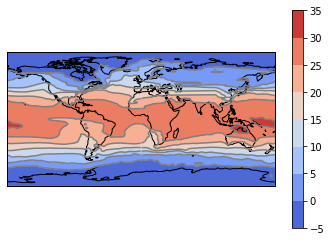

In [73]:
newData=np.zeros((nt,nyCESM,nxCESM))
for i in range(0,nt):
    
    Z1=shiftpacanoms[0,:,:]
    X1=shiftlons
    Y1=lats
    f=interp2d(X1,Y1,Z1)

    X2=lonsCESM
    Y2=latsCESM
    Z2=f(X2,Y2)
    
    newData[i,:,:]=climoCESM[i,:,:]+Z2
    
    # Plot
ax=plt.axes(projection=ccrs.PlateCarree())
clevs = np.arange(220,340,10)
contour=ax.contourf(lonsCESM, latsCESM, newData[i,:,:], cmap=plt.cm.coolwarm, transform = ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(contour)
contourlines=ax.contour(lonsCESM,latsCESM,newData[i,:,:],transform=ccrs.PlateCarree(),colors='gray')
plt.show()
    

In [74]:
ofname='%sSSTPACPOS.nc' %(cesmpath)
toexclude = ['SST_cpl']

with Dataset(inFileClimoCESM,"r") as src, Dataset(ofname, "w") as dst:
    # copy global attributes all at once via dictionary
    dst.setncatts(src.__dict__)
    # copy dimensions
    for name, dimension in src.dimensions.items():
        dst.createDimension(
            name, (len(dimension) if not dimension.isunlimited() else None))
    # copy all file data except for the excluded
    for name, variable in src.variables.items():
        if name not in toexclude:
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            dst[name][:] = src[name][:]
            # copy variable attributes all at once via dictionary
            dst[name].setncatts(src[name].__dict__)
        else:
            x = dst.createVariable(name, variable.datatype, variable.dimensions)
            dst[name][:] = newData
            dst[name].setncatts(src[name].__dict__)
 